In [7]:
import rebound
import reboundx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

try:
    plt.style.use('paper')
except:
    pass

In [8]:
def makesim():
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=1.)
    sim.add(m=1.e-4, a=1.)
    sim.add(m=1.e-4, a=1.5)
    sim.move_to_com()
    return sim

In [3]:
def order2(sim, dt):
    sim.kepler_step(dt/2.)
    sim.interaction_step(dt)
    sim.kepler_step(dt/2.)
    sim.t += dt

In [4]:
def KI(sim, dt):
    sim.interaction_step(dt)
    sim.kepler_step(dt)
    sim.t += dt

In [5]:
def MIS1st(sim, dt):
    sim.kepler_step(-dt/2.)
    sim.integrator_reset()
    sim.integrate(sim.t+dt)
    sim.kepler_step(+dt/2.)
    sim.integrator_reset()
    sim.t += dt

In [6]:
def MIS2nd(sim, dt):
    sim.interaction_step(-dt/6.)
    sim.integrator_reset()
    sim.integrate(sim.t+dt)
    sim.interaction_step(-dt/6.)
    sim.integrator_reset()
    sim.kepler_step(-dt/2.)
    sim.integrator_reset()
    sim.interaction_step(dt/3.)
    sim.integrator_reset()
    sim.kepler_step(dt/2.)
    sim.integrator_reset()
    sim.t += dt

In [19]:
%%time
simKI = makesim() # K \circ I split scheme
simKI.integrator="none"
rebxKI = reboundx.Extras(simKI)
kepler = rebxKI.load_operator("kepler")
inter = rebxKI.load_operator("interaction")
rebxKI.add_operator(kepler, dt_fraction=1., timing="post")
rebxKI.add_operator(inter, dt_fraction=1., timing="post")

simMIS = makesim() # Modified integration scheme Eq 22
simMIS.integrator="none"
rebxMIS = reboundx.Extras(simMIS)
kepler = rebxMIS.load_operator("kepler")
ias15 = rebxMIS.load_operator("ias15")
rebxMIS.add_operator(kepler, dt_fraction=1./2., timing="post")
rebxMIS.add_operator(ias15, dt_fraction=1., timing="post")
rebxMIS.add_operator(kepler, dt_fraction=-1./2., timing="post")

simKI.dt = 0.037*simKI.particles[1].P
simMIS.dt = 0.037*simKI.particles[1].P
Nout = 300

E0 = simKI.calculate_energy()
EerrKI = np.zeros(Nout)
EerrMIS = np.zeros(Nout)
times = np.linspace(0, 10*simKI.particles[1].P, Nout)

for i, time in enumerate(times):
    simKI.integrate(time)
    simMIS.integrate(time)
    EKI = simKI.calculate_energy()
    EMIS = simMIS.calculate_energy()
    EerrKI[i] = np.abs((EKI-E0)/E0)
    EerrMIS[i] = np.abs((EMIS-E0)/E0)  

CPU times: user 39.9 ms, sys: 0 ns, total: 39.9 ms
Wall time: 38.7 ms


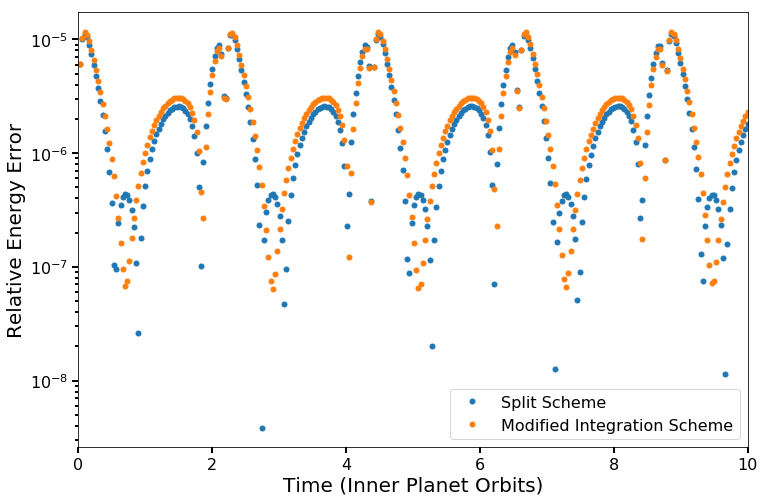

In [21]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, EerrKI, '.', label='Split Scheme')
ax.plot(times, EerrMIS, '.', label='Modified Integration Scheme')
ax.set_yscale('log')
ax.set_xlabel('Time (Inner Planet Orbits)')
ax.set_ylabel('Relative Energy Error')
ax.set_xlim([0,10])
ax.legend()
fig.savefig("modifiedintegrationschemes.pdf", bbox_inches='tight')